In [63]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# Sales Analysis and Forecasting for Istanbul 

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 12 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [64]:
data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['HcoType', 'SalesRegionID'] # 'SalesRegionID_x','SalesRegionID_y', 
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity', 'Week', 'Quarter', 'Month', 'Year']
boolean_cols = ['IsReturn', 'IsMrsOrder', 'Status']

data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

# if sales region x and y are the same save 
data = data[data['SalesRegionID_x'] == data['SalesRegionID_y']]

# merge region cols 
data['SalesRegionID'] = data['SalesRegionID_x'].combine_first(data['SalesRegionID_y'])
data.drop(columns=['SalesRegionID_x', 'SalesRegionID_y'], inplace=True)

data['Status'] = data['Status'].apply(lambda x: True if x == 'Active' else False)

In [65]:
# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)

# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
data.info()
raw_data = data.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 4111852 entries, 126 to 4201058
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   MainDistID     object        
 1   DistID         object        
 2   Date           datetime64[ns]
 3   HcoID          object        
 4   BrandID        int64         
 5   SkuID          object        
 6   IsReturn       bool          
 7   PaidQty        int64         
 8   FGQty          int64         
 9   IsMrsOrder     bool          
 10  HcoType        category      
 11  District       object        
 12  Status         bool          
 13  TotalQuantity  int64         
 14  Week           int64         
 15  Month          int64         
 16  Quarter        int64         
 17  Year           int64         
 18  SalesRegionID  category      
dtypes: bool(3), category(2), datetime64[ns](1), int64(8), object(5)
memory usage: 619.2+ MB


# SKU and District Selection

In [66]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = segment_1_sku_ids + segment_2_sku_ids

data = data[data['SkuID'].isin(all_sku_ids)]

In [67]:
highest_districts = ['PENDİK','GAZİOSMANPAŞA','KÜÇÜKÇEKMECE','ÜMRANİYE','FATİH']
data = data[data['District'].isin(highest_districts)]

# convert District column to 'category' data type

data['District'] = data['District'].astype('category')

In [68]:
data.describe()

,Date,BrandID,PaidQty,FGQty,TotalQuantity,Week,Month,Quarter,Year
count,179351,179351.000000,179351.000000,179351.000000,179351.000000,179351.000000,179351.000000,179351.000000,179351.000000
mean,2020-07-12 22:13:29.759633408,36.090253,5.987823,0.663760,6.548667,26.659918,6.531316,2.508846,2020.031101
min,2019-01-01 00:00:00,15.000000,0.000000,0.000000,-216.000000,1.000000,1.000000,1.000000,2019.000000
25%,2019-11-06 00:00:00,20.000000,2.000000,0.000000,2.000000,12.000000,3.000000,1.000000,2019.000000
50%,2020-07-10 00:00:00,29.000000,4.000000,0.000000,4.000000,26.000000,6.000000,2.000000,2020.000000
75%,2021-04-02 00:00:00,72.000000,6.000000,0.000000,6.000000,41.000000,10.000000,4.000000,2021.000000
max,2021-12-31 00:00:00,72.000000,750.000000,750.000000,1500.000000,53.000000,12.000000,4.000000,2021.000000
std,NaN,21.692538,10.523115,6.282799,15.926494,15.793860,3.619867,1.154199,0.808819


In [69]:
data.describe(include=['category', 'object'])

,MainDistID,DistID,HcoID,SkuID,HcoType,District,SalesRegionID
count,179351,179351,179351,179351,179351,179351,179351
unique,14,36,1122,7,1,5,30
top,2879266,2878817,2856200,568,P,KÜÇÜKÇEKMECE,342101
freq,69437,52340,720,49859,179351,39341,21895


In [70]:
# Grouping by Sales Region and calculating aggregate metrics
district_agg = data.groupby('District').agg({
    'PaidQty': ['sum', 'mean', 'std'],
    'FGQty': ['sum', 'mean', 'std'],
    'TotalQuantity': ['sum', 'mean', 'std']
}).reset_index()

district_agg.columns = ['District', 'PaidQty_sum', 'PaidQty_mean', 'PaidQty_std', 
                            'FGQty_sum', 'FGQty_mean', 'FGQty_std',
                            'TotalQuantity_sum', 'TotalQuantity_mean', 'TotalQuantity_std']

print(district_agg)

        District  PaidQty_sum  PaidQty_mean  PaidQty_std  FGQty_sum  \
0          FATİH       195416      5.231321     7.441644      14511   
1  GAZİOSMANPAŞA       230514      6.627775    13.205077      27965   
2   KÜÇÜKÇEKMECE       221049      5.618795    10.540488      20436   
3         PENDİK       225908      6.783617    11.261846      31118   
4       ÜMRANİYE       201035      5.814798     9.423316      25016   

   FGQty_mean  FGQty_std  TotalQuantity_sum  TotalQuantity_mean  \
0    0.388462   3.647547             207681            5.559657   
1    0.804054   8.490928             255257            7.339189   
2    0.519458   6.227235             239099            6.077604   
3    0.934418   6.578520             250376            7.518347   
4    0.723570   5.644751             222097            6.424001   

   TotalQuantity_std  
0          10.305968  
1          20.662225  
2          15.863220  
3          16.859351  
4          14.444544  


# Encoding Categorical Variables

In [71]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df_cleaned = data.copy()
# 'DistID', 'HcoID', 'District', 'Status', 'IsReturn', 
df_cleaned = df_cleaned[['MainDistID', 'District', 'TotalQuantity', 'SalesRegionID', 'SkuID', 'Date', 'Year', 'Quarter', 'Month', 'Week']]

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179351 entries, 1264 to 4191737
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   MainDistID     179351 non-null  object        
 1   District       179351 non-null  category      
 2   TotalQuantity  179351 non-null  int64         
 3   SalesRegionID  179351 non-null  category      
 4   SkuID          179351 non-null  object        
 5   Date           179351 non-null  datetime64[ns]
 6   Year           179351 non-null  int64         
 7   Quarter        179351 non-null  int64         
 8   Month          179351 non-null  int64         
 9   Week           179351 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(5), object(2)
memory usage: 12.7+ MB


In [72]:
# Label Encoding for binary categorical variables
label_encoder = LabelEncoder()

# One-Hot Encoding for other categorical variables
df_encoded = pd.get_dummies(df_cleaned, columns=['MainDistID', 'District'])

print('Data after encoding:')
df_encoded.head()

Data after encoding:


,TotalQuantity,SalesRegionID,SkuID,Date,Year,Quarter,Month,Week,MainDistID_2879231,MainDistID_2879236,...,MainDistID_2879276,MainDistID_2886479,MainDistID_2908099,MainDistID_2915715,MainDistID_2918750,District_FATİH,District_GAZİOSMANPAŞA,District_KÜÇÜKÇEKMECE,District_PENDİK,District_ÜMRANİYE
1264,1,341903,319,2019-01-03,2019,1,1,1,False,False,...,False,False,False,False,False,False,False,True,False,False
1267,1,341903,319,2019-01-07,2019,1,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
1268,1,341903,319,2019-01-07,2019,1,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
1270,1,341903,319,2019-01-08,2019,1,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
1273,4,341903,319,2019-01-14,2019,1,1,3,False,False,...,False,False,False,False,False,False,False,True,False,False


# Sales Analysis

In [73]:
monthly_data = df_cleaned.copy()

monthly_data = monthly_data.groupby(['Year', 'Month', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
monthly_data

,Year,Month,SkuID,TotalQuantity
0,2019,1,1018,881
1,2019,1,1050,4317
2,2019,1,319,3362
3,2019,1,509,2820
4,2019,1,568,11548
...,...,...,...,...
247,2021,12,319,5877
248,2021,12,509,2547
249,2021,12,568,10953
250,2021,12,578,6199


## Plots

### Total Quantity by SKU Function

In [74]:
def plot_total_quantity(sku_id, data, title='Total Quantity by Quarter', xlabel='Quarter', ylabel='Total Quantity'):
    sku = data[data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    
    # define if the x is week, month or quarter
    if xlabel == 'Quarter':
        x = sku['Year'].astype(str) + '-' + sku['Quarter'].astype(str)
    elif xlabel == 'Month':
        x = sku['Year'].astype(str) + '-' + sku['Month'].astype(str)
    else:
        x = sku['Year'].astype(str) + '-' + sku['Week'].astype(str)
        
    plt.plot(x, sku['TotalQuantity'])
    
    plt.title(f'SKU {sku_id} - {title}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

### Implementing Moving Average for each SKU to see the trend and seasonality

SKU 568


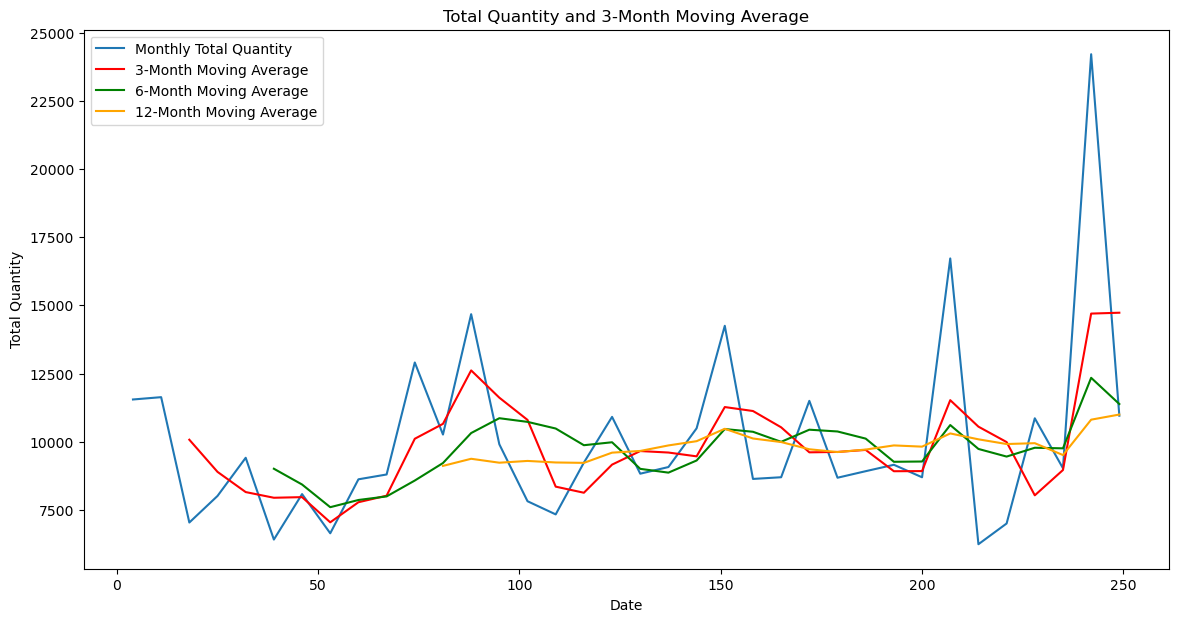

SKU 578


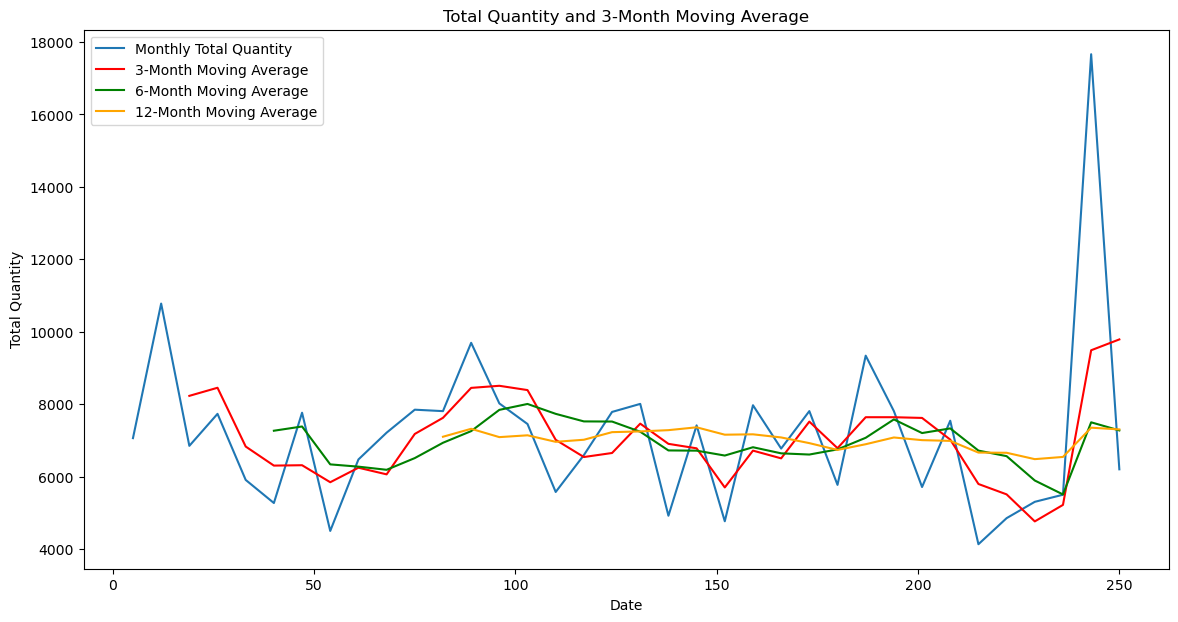

SKU 1050


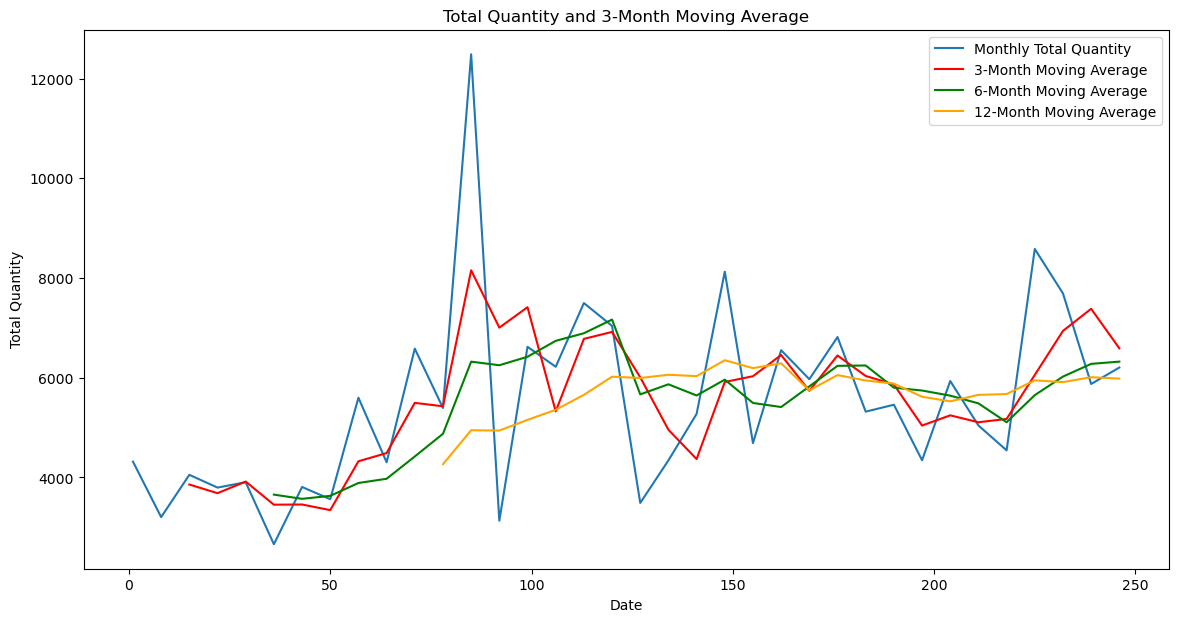

SKU 319


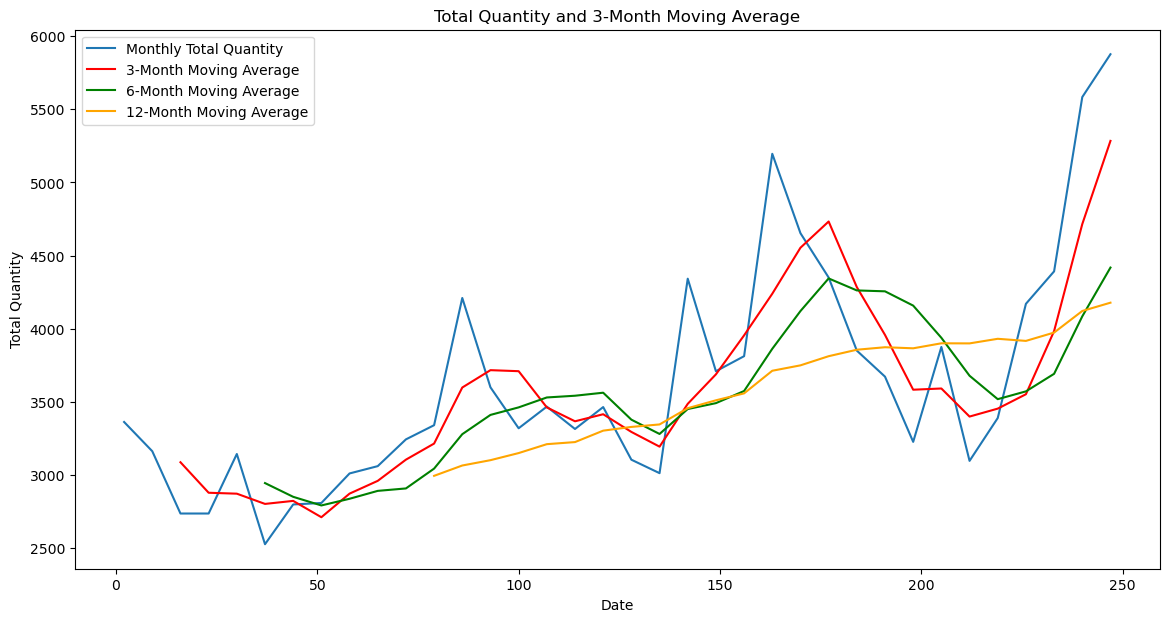

SKU 509


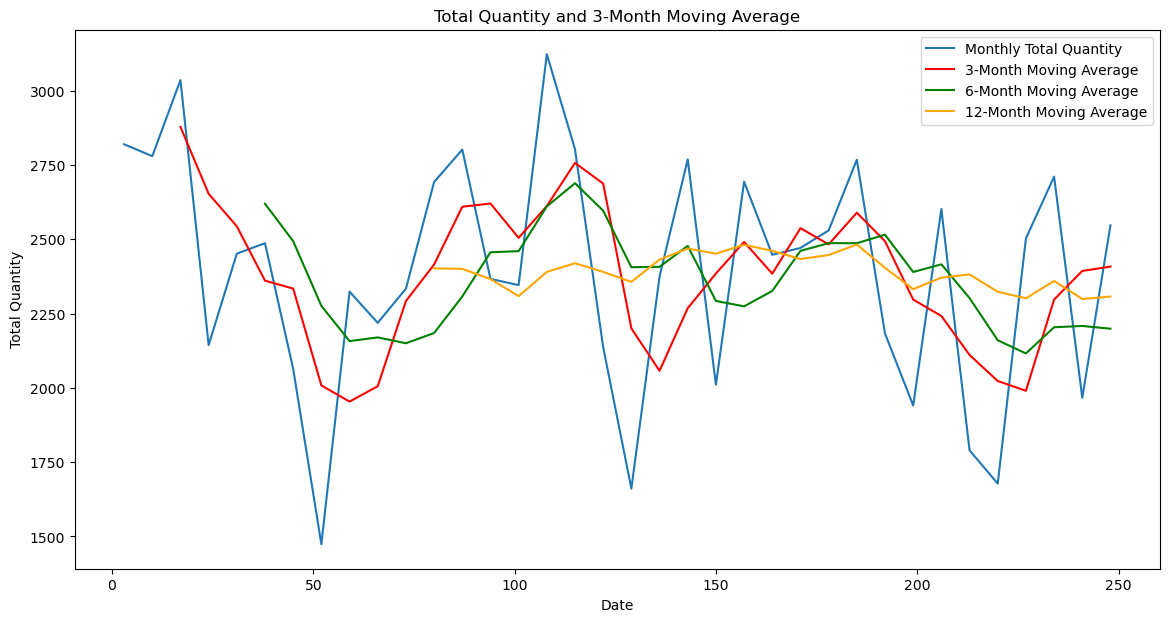

SKU 615


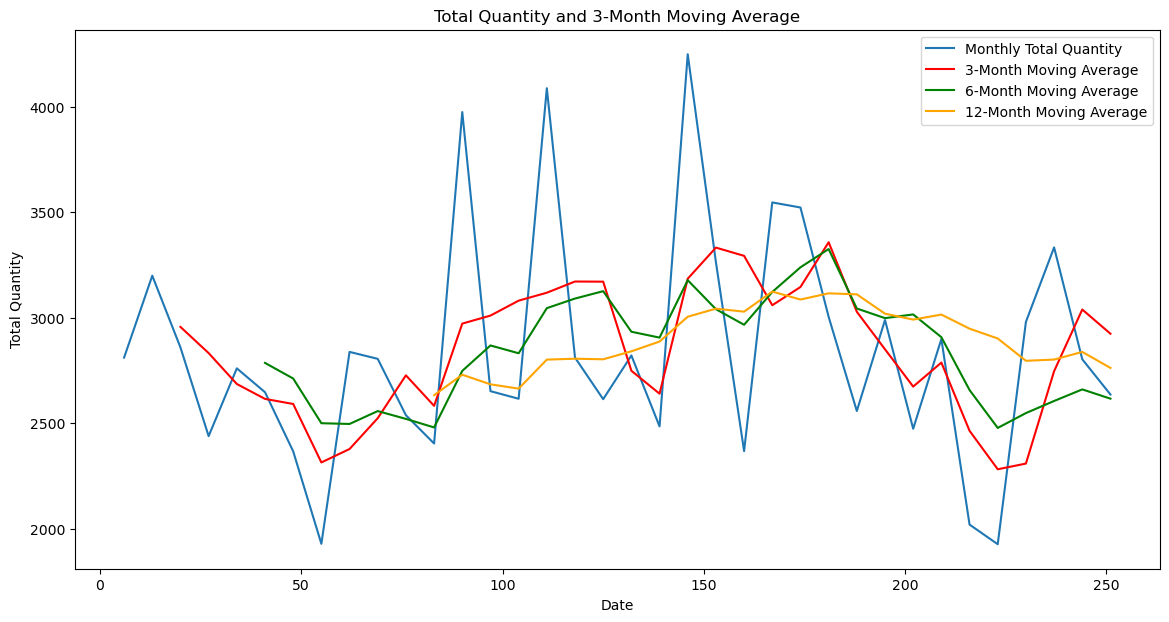

SKU 1018


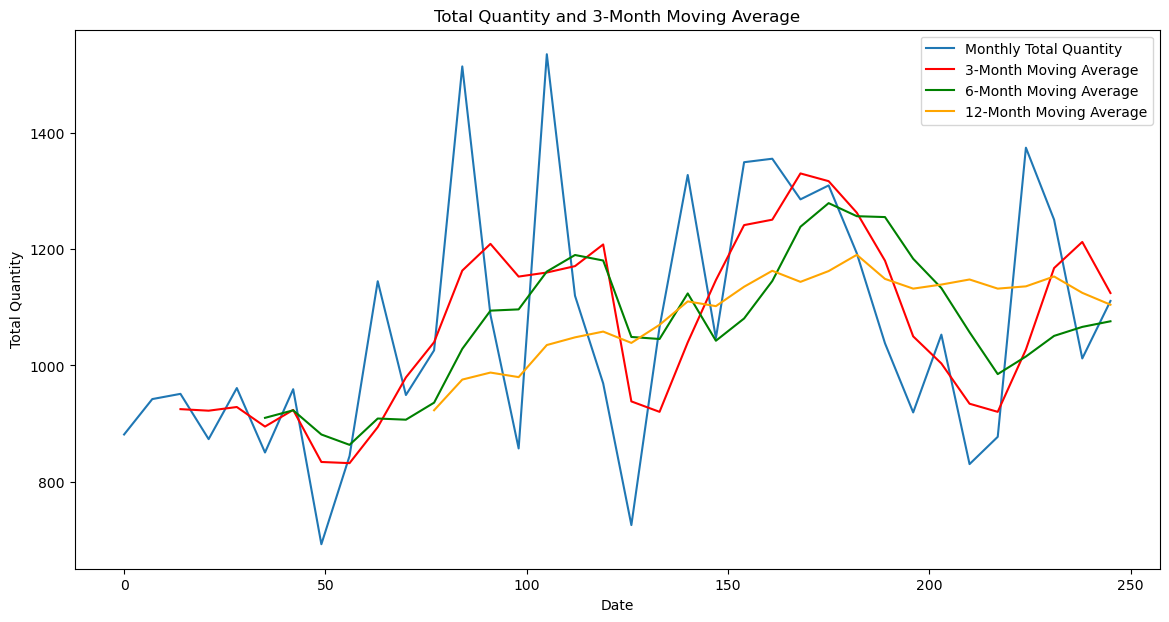

In [75]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Calculate the moving average
    sku_data['Moving_Average_3'] = sku_data['TotalQuantity'].rolling(window=3).mean()
    sku_data['Moving_Average_6'] = sku_data['TotalQuantity'].rolling(window=6).mean()
    sku_data['Moving_Average_12'] = sku_data['TotalQuantity'].rolling(window=12).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(sku_data['TotalQuantity'], label='Monthly Total Quantity')
    
    plt.plot(sku_data['Moving_Average_3'], label='3-Month Moving Average', color='red')
    plt.plot(sku_data['Moving_Average_6'], label='6-Month Moving Average', color='green')
    plt.plot(sku_data['Moving_Average_12'], label='12-Month Moving Average', color='orange')

    plt.title('Total Quantity and 3-Month Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity')
    plt.legend()
    plt.show()

# Quarterly Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly. It should be 12 rows in total for every SKU.

In [76]:
quarterly_data = df_cleaned.copy()

quarterly_data = quarterly_data.groupby(['Year', 'Quarter', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
quarterly_data

,Year,Quarter,SkuID,TotalQuantity
0,2019,1,1018,2774
1,2019,1,1050,11575
2,2019,1,319,9260
3,2019,1,509,8636
4,2019,1,568,30216
...,...,...,...,...
79,2021,4,319,15853
80,2021,4,509,7225
81,2021,4,568,44191
82,2021,4,578,29360


## Total Quantity Plot for each SKU

SKU 1018


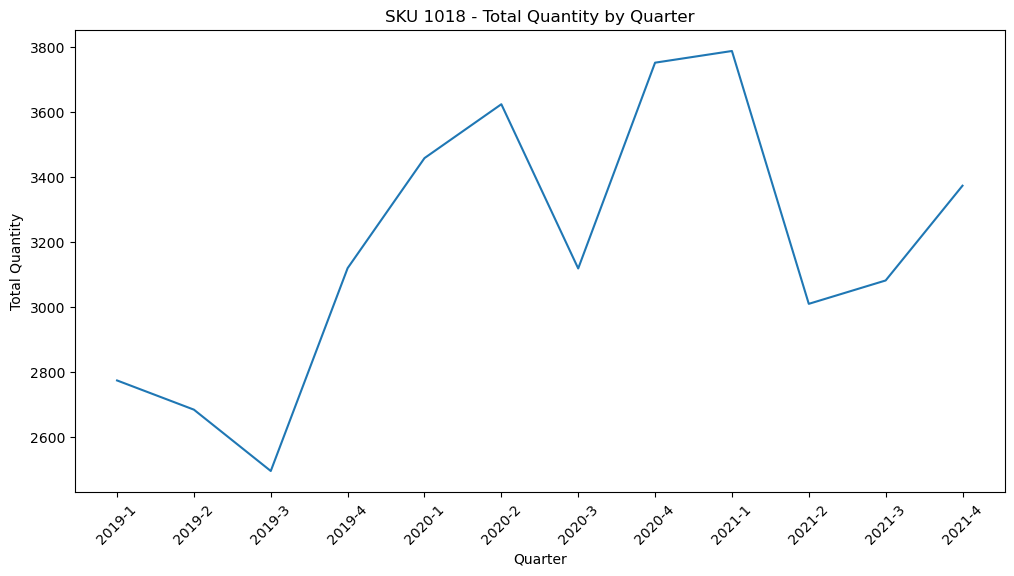

SKU 1050


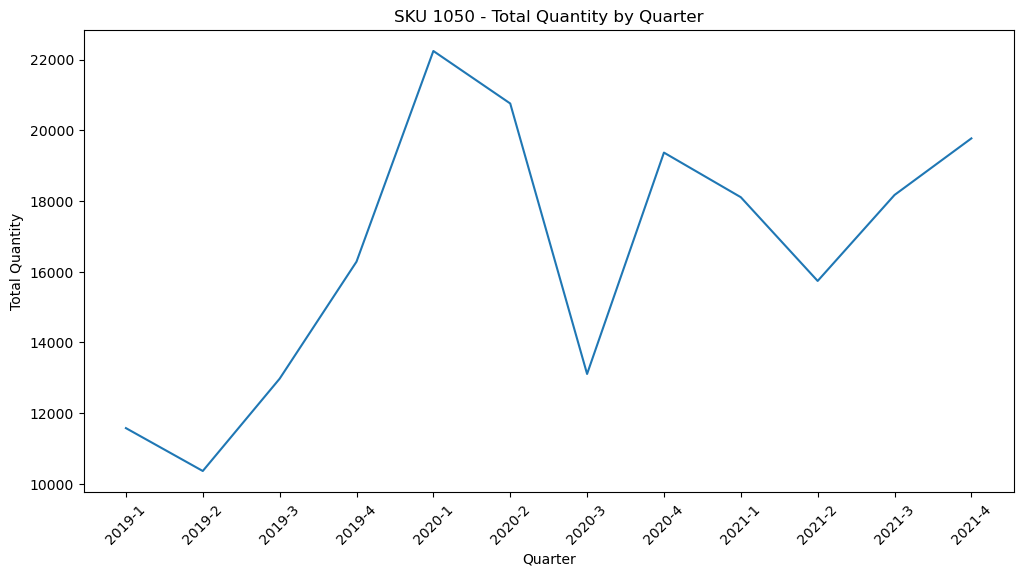

SKU 319


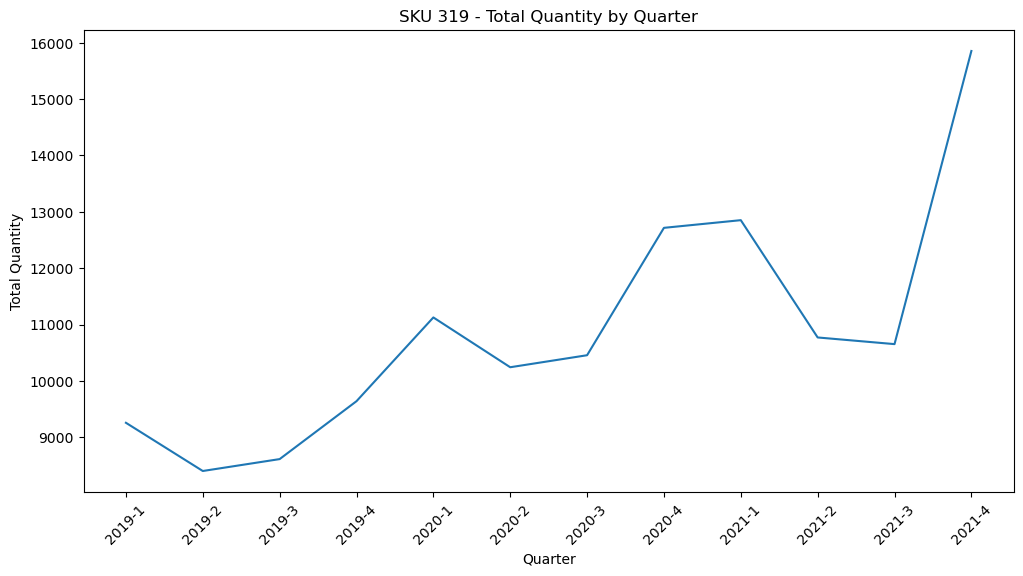

SKU 509


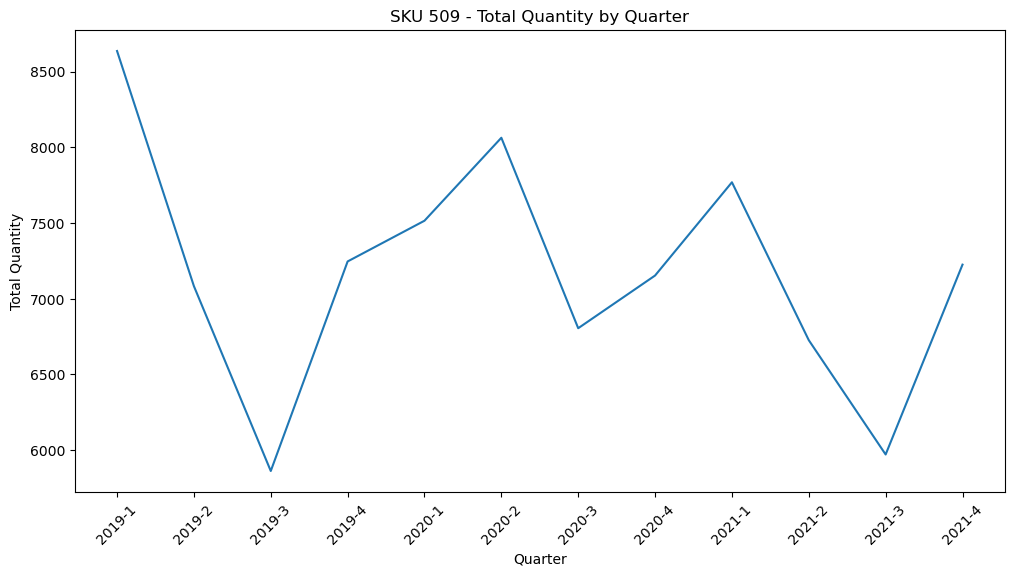

SKU 568


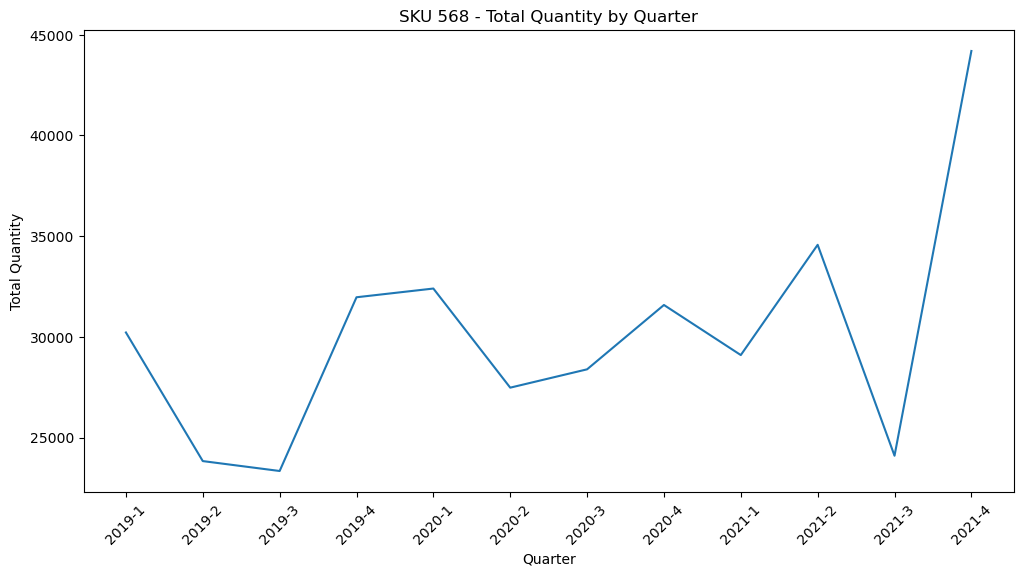

SKU 578


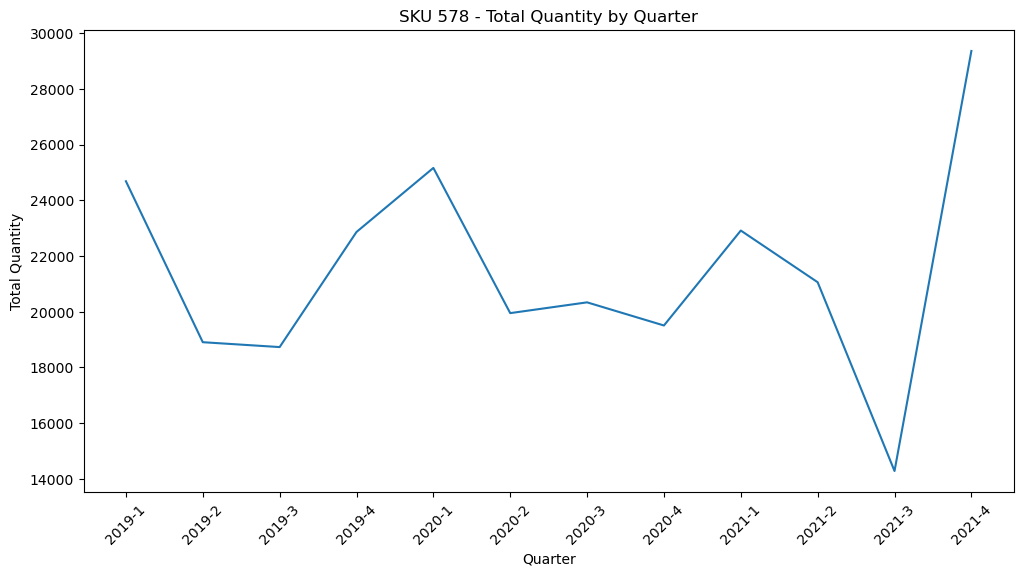

SKU 615


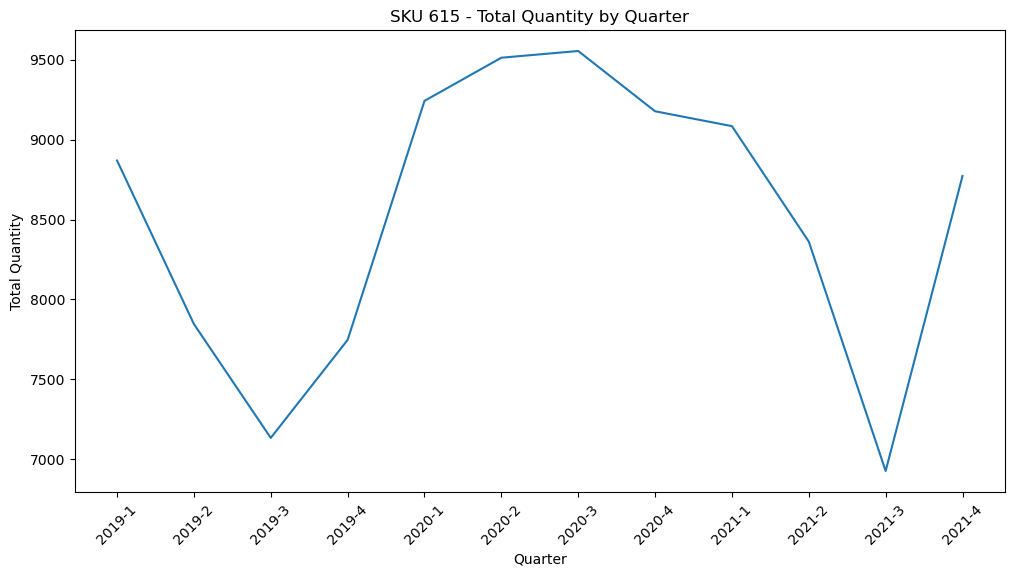

In [77]:
for sku in quarterly_data['SkuID'].unique():
    print(f'SKU {sku}')
    plot_total_quantity(sku, data=quarterly_data)

# R-squared Analysis

Calculate the R-squared value for each SKU to evaluate the model performance.

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def analyze_feature_effects(df, test_size=0.2, random_state=42, additional_cols=None, time_cols=None):
    categorical_cols = []
    
    if time_cols is None:
        time_cols = ['Year', 'Quarter']
        
    if additional_cols is None:
        additional_cols = ['District']
        
    for col in additional_cols:
        if col not in df.columns:
            raise ValueError(f'Column "{col}" not found in the DataFrame.')
        
        # if the column is categorical or object, convert it to category data type
        if df[col].dtype.name in ['category', 'object']:
            df[col] = df[col].astype('category')
            categorical_cols.append(col)

    results = []

    for sku in df['SkuID'].unique():
        df_sku = df[df['SkuID'] == sku].copy()
        df_encoded = pd.get_dummies(df_sku, columns=categorical_cols)
        X = df_encoded.drop(['TotalQuantity', 'SkuID'] + time_cols, axis=1)
        y = df_encoded['TotalQuantity']

        if len(df_encoded) > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            coefficients = dict(zip(X.columns, model.coef_))
            results.append((sku, round(r2, 3), coefficients))
        else:
            results.append((sku, None, None))

    return results

## Assigning the columns


In [79]:
df_cleaned_selected = df_cleaned.copy()
print(df_cleaned_selected.columns)

Index(['MainDistID', 'District', 'TotalQuantity', 'SalesRegionID', 'SkuID',
       'Date', 'Year', 'Quarter', 'Month', 'Week'],
      dtype='object')


In [80]:
time_cols = ['Year', 'Month']
additional_cols = ['District', 'MainDistID']

df_cleaned_selected = df_cleaned_selected.groupby(['SkuID'] +
    time_cols + additional_cols
).agg({'TotalQuantity': 'sum'}).reset_index()

print(df_cleaned_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   SkuID          17640 non-null  object  
 1   Year           17640 non-null  int64   
 2   Month          17640 non-null  int64   
 3   District       17640 non-null  category
 4   MainDistID     17640 non-null  object  
 5   TotalQuantity  17640 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 706.6+ KB
None


In [81]:
df_cleaned_selected

,SkuID,Year,Month,District,MainDistID,TotalQuantity
0,1018,2019,1,FATİH,2879231,0
1,1018,2019,1,FATİH,2879236,0
2,1018,2019,1,FATİH,2879239,0
3,1018,2019,1,FATİH,2879243,3
4,1018,2019,1,FATİH,2879249,147
...,...,...,...,...,...,...
17635,615,2021,12,ÜMRANİYE,2879276,41
17636,615,2021,12,ÜMRANİYE,2886479,0
17637,615,2021,12,ÜMRANİYE,2908099,0
17638,615,2021,12,ÜMRANİYE,2915715,34


In [82]:
# Run the analysis for each SKU
results = analyze_feature_effects(df_cleaned_selected, additional_cols=additional_cols, time_cols=time_cols)

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results, columns=['SkuID', 'R_squared', 'Coefficients'])
results_df

,SkuID,R_squared,Coefficients
0,1018,0.630,"{'District_FATİH': 4787793991669.125, 'Distric..."
1,1050,0.622,"{'District_FATİH': 19211728254190.996, 'Distri..."
2,319,0.839,"{'District_FATİH': 36350101702841.58, 'Distric..."
3,509,0.777,"{'District_FATİH': 10344867221299.02, 'Distric..."
4,568,0.674,"{'District_FATİH': -39241242084399.1, 'Distric..."
5,578,0.553,"{'District_FATİH': 54272797297608.31, 'Distric..."
6,615,0.659,"{'District_FATİH': 9665715727540.404, 'Distric..."


### Interpretation for R-squared Analysis

Based on the R-squared analysis, the following columns are used for the analysis in addition to the time columns:

--------

#### 'Year', 'Quarter', 'District', 'MainDistID', 'DistID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'MainDistID', 'DistID']
```

The R-squared values for each SKU are as follows:

| Index | SKU  | R_squared |
|-------|------|-----------|
| 0     | 1018 | 0.047     |
| 1     | 1050 | 0.050     |
| 2     | 319  | 0.053     |
| 3     | 509  | 0.052     |
| 4     | 568  | 0.054     |
| 5     | 578  | 0.045     |
| 6     | 615  | 0.046     |

### Observations
- **Consistent Scores:** Across all SKUs, the evaluation scores range from 0.045 to 0.054, indicating relatively consistent performance across the board.
- **Low Variability:** The evaluation scores do not exhibit significant variability, suggesting that the model performs similarly for different SKUs.

========

#### 'Year', 'Quarter', 'District', 'MainDistID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'MainDistID']
```

The R-squared values for each SKU are as follows:

| Index | SKU | R_squared |
| --- | --- | --- |
| 0 | 1018 | 0.816 |
| 1 | 1050 | 0.767 |
| 2 | 319 | 0.874 |
| 3 | 509 | 0.863 |
| 4 | 568 | 0.817 |
| 5 | 578 | 0.686 |
| 6 | 615 | 0.793 |

#### 'Year', 'Month', 'District', 'MainDistID'
```python
time_cols = ['Year', 'Month']
additional_cols = ['District', 'MainDistID']
```

| Index | SKU ID | Evaluation Score |
| --- | --- | --- |
| 0 | 1018 | 0.634 |
| 1 | 1050 | 0.622 |
| 2 | 319 | 0.844 |
| 3 | 509 | 0.780 |
| 4 | 568 | 0.677 |
| 5 | 578 | 0.556 |
| 6 | 615 | 0.659 |

### Interpretation

-   **High Evaluation Score**: SKU 319 has the highest evaluation score (0.844), indicating strong performance.
-   **Moderate Evaluation Scores**: SKUs 509, 568, 1018, and 615 have moderate evaluation scores ranging from 0.634 to 0.780.
-   **Lower Evaluation Scores**: SKUs 1050 and 578 have the lowest evaluation scores, with scores of 0.622 and 0.

### Observations
- **Improved Scores:** The evaluation scores have significantly improved, ranging from 0.686 to 0.874, indicating better performance.
- **High Variability:** The evaluation scores exhibit more variability compared to the previous analysis, suggesting that the model's performance varies across different SKUs.
- **Top Performers:** SKUs 319 and 509 have the highest evaluation scores, indicating that the model performs exceptionally well for these SKUs.
- **SKU 578:** SKU 578 has the lowest evaluation score, suggesting that the model may not perform as effectively for this SKU.
- **Overall Performance:** The model performs well across most SKUs, with the majority of evaluation scores above 0.75, indicating a good fit to the data.


In [83]:
import numpy as np

# Convert coefficients to a DataFrame for easier analysis
coefficients_df = pd.DataFrame()
coefficients_df['SkuID'] = results_df['SkuID']

for i, row in results_df.iterrows():
    coefficients = row['Coefficients']
    if coefficients is not None:
        for col, coef in coefficients.items():
            col_name = f'{col}'
            if col_name not in coefficients_df:
                coefficients_df[col_name] = np.nan
            coefficients_df.loc[i, col_name] = coef
        
coefficients_df    

,SkuID,District_FATİH,District_GAZİOSMANPAŞA,District_KÜÇÜKÇEKMECE,District_PENDİK,District_ÜMRANİYE,MainDistID_2879231,MainDistID_2879236,MainDistID_2879239,MainDistID_2879243,MainDistID_2879249,MainDistID_2879254,MainDistID_2879258,MainDistID_2879260,MainDistID_2879266,MainDistID_2879276,MainDistID_2886479,MainDistID_2908099,MainDistID_2915715,MainDistID_2918750
0,1018,4.787794e+12,4.787794e+12,4.787794e+12,4.787794e+12,4.787794e+12,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13,1.764795e+13
1,1050,1.921173e+13,1.921173e+13,1.921173e+13,1.921173e+13,1.921173e+13,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14,-1.263161e+14
2,319,3.635010e+13,3.635010e+13,3.635010e+13,3.635010e+13,3.635010e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13,4.633685e+13
3,509,1.034487e+13,1.034487e+13,1.034487e+13,1.034487e+13,1.034487e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13,-2.825570e+13
4,568,-3.924124e+13,-3.924124e+13,-3.924124e+13,-3.924124e+13,-3.924124e+13,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14,1.618781e+14
5,578,5.427280e+13,5.427280e+13,5.427280e+13,5.427280e+13,5.427280e+13,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14,-2.183202e+14
6,615,9.665716e+12,9.665716e+12,9.665716e+12,9.665716e+12,9.665716e+12,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13,-1.531985e+13


<Figure size 1600x1000 with 0 Axes>

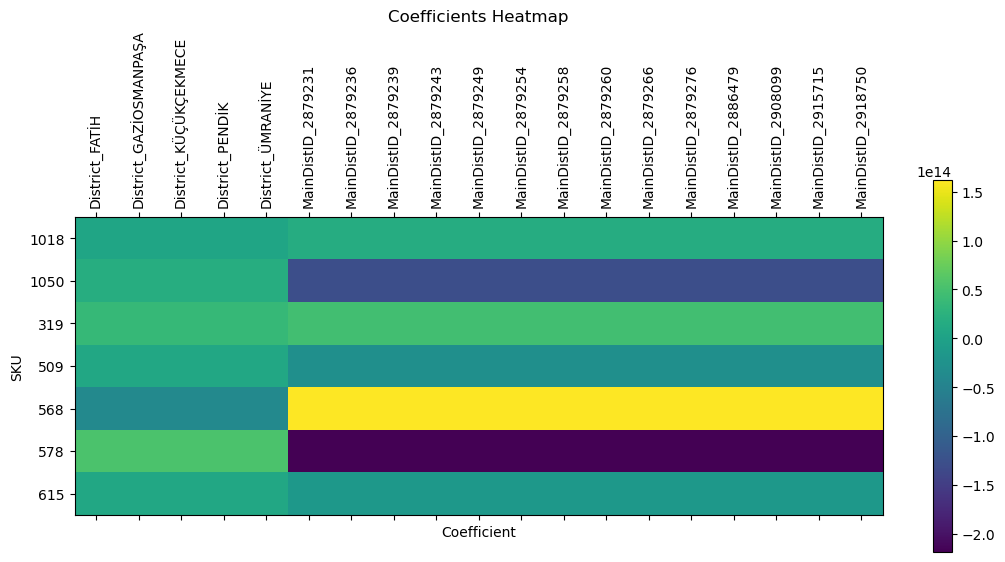

In [84]:
# heatmap for coefficients
plt.figure(figsize=(16, 10))
plt.matshow(coefficients_df.drop('SkuID', axis=1), cmap='viridis')
plt.colorbar()
plt.xticks(range(len(coefficients_df.columns) - 1), coefficients_df.columns[1:], rotation=90)
plt.yticks(range(len(coefficients_df)), coefficients_df['SkuID'])
plt.xlabel('Coefficient')
plt.ylabel('SKU')
plt.title('Coefficients Heatmap')
plt.show()



In [85]:
avg_maindistid_coefficients = coefficients_df.filter(regex='MainDistID').mean()

avg_maindistid_coefficients_df = pd.DataFrame(avg_maindistid_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for MainDistID:')
avg_maindistid_coefficients_df

Average Coefficients for MainDistID:


,Average Coefficient
MainDistID_2879231,-2.319271e+13
MainDistID_2879236,-2.319271e+13
MainDistID_2879239,-2.319271e+13
MainDistID_2879243,-2.319271e+13
MainDistID_2879249,-2.319271e+13
MainDistID_2879254,-2.319271e+13
MainDistID_2879258,-2.319271e+13
MainDistID_2879260,-2.319271e+13
MainDistID_2879266,-2.319271e+13
MainDistID_2879276,-2.319271e+13


In [86]:
avg_district_coefficients = coefficients_df.filter(regex='District').mean()

avg_district_coefficients_df = pd.DataFrame(avg_district_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for District:')
avg_district_coefficients_df

Average Coefficients for District:


,Average Coefficient
District_FATİH,1.362739e+13
District_GAZİOSMANPAŞA,1.362739e+13
District_KÜÇÜKÇEKMECE,1.362739e+13
District_PENDİK,1.362739e+13
District_ÜMRANİYE,1.362739e+13


In [87]:
avg_distid_coefficients = coefficients_df.filter(regex='DistID').mean()

avg_distid_coefficients_df = pd.DataFrame(avg_distid_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for DistID:')
avg_distid_coefficients_df

Average Coefficients for DistID:


,Average Coefficient
MainDistID_2879231,-2.319271e+13
MainDistID_2879236,-2.319271e+13
MainDistID_2879239,-2.319271e+13
MainDistID_2879243,-2.319271e+13
MainDistID_2879249,-2.319271e+13
MainDistID_2879254,-2.319271e+13
MainDistID_2879258,-2.319271e+13
MainDistID_2879260,-2.319271e+13
MainDistID_2879266,-2.319271e+13
MainDistID_2879276,-2.319271e+13


# Feature Importance Analysis

Calculate the feature importance for each SKU to identify the most important features for predicting the total quantity.
    

In [88]:
from sklearn.ensemble import RandomForestRegressor

def analyze_feature_importance(df, test_size=0.2, random_state=42, additional_cols=None, time_cols=None):
    categorical_cols = []
    
    if time_cols is None:
        time_cols = ['Year', 'Quarter']
        
    if additional_cols is None:
        additional_cols = ['District']
        
    for col in additional_cols:
        if col not in df.columns:
            raise ValueError(f'Column "{col}" not found in the DataFrame.')
        
        # if the column is categorical or object, convert it to category data type
        if df[col].dtype.name in ['category', 'object']:
            df[col] = df[col].astype('category')
            categorical_cols.append(col)

    results = []

    for sku in df['SkuID'].unique():
        df_sku = df[df['SkuID'] == sku].copy()
        df_encoded = pd.get_dummies(df_sku, columns=categorical_cols)
        X = df_encoded.drop(['TotalQuantity', 'SkuID'] + time_cols, axis=1)
        y = df_encoded['TotalQuantity']

        if len(df_encoded) > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            model = RandomForestRegressor(random_state=random_state)
            model.fit(X_train, y_train)
            feature_importances = dict(zip(X.columns, model.feature_importances_))
            results.append((sku, feature_importances))
        else:
            results.append((sku, None))

    return results

In [89]:
# Run the analysis for each SKU
results = analyze_feature_importance(df_cleaned_selected, additional_cols=additional_cols, time_cols=time_cols)

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results, columns=['SkuID', 'Feature_Importance'])

results_df

,SkuID,Feature_Importance
0,1018,"{'District_FATİH': 0.012192299681915778, 'Dist..."
1,1050,"{'District_FATİH': 0.008031934200187553, 'Dist..."
2,319,"{'District_FATİH': 0.016838869084708816, 'Dist..."
3,509,"{'District_FATİH': 0.020179814439279457, 'Dist..."
4,568,"{'District_FATİH': 0.005332132185587181, 'Dist..."
5,578,"{'District_FATİH': 0.02722229791127242, 'Distr..."
6,615,"{'District_FATİH': 0.02977729974479783, 'Distr..."


In [90]:
# Convert feature importances to a DataFrame for easier analysis

feature_importances_df = pd.DataFrame()
feature_importances_df['SkuID'] = results_df['SkuID']

for i, row in results_df.iterrows():
    feature_importances = row['Feature_Importance']
    if feature_importances is not None:
        for col, importance in feature_importances.items():
            col_name = f'{col}'
            if col_name not in feature_importances_df:
                feature_importances_df[col_name] = np.nan
            feature_importances_df.loc[i, col_name] = importance
            
feature_importances_df

,SkuID,District_FATİH,District_GAZİOSMANPAŞA,District_KÜÇÜKÇEKMECE,District_PENDİK,District_ÜMRANİYE,MainDistID_2879231,MainDistID_2879236,MainDistID_2879239,MainDistID_2879243,MainDistID_2879249,MainDistID_2879254,MainDistID_2879258,MainDistID_2879260,MainDistID_2879266,MainDistID_2879276,MainDistID_2886479,MainDistID_2908099,MainDistID_2915715,MainDistID_2918750
0,1018,0.012192,0.038619,0.005804,0.076715,0.007582,0.000413,0.000571,0.000000e+00,1.288130e-07,0.251690,0.181138,0.000000e+00,4.035607e-07,0.420245,0.000773,0.000040,0.000000e+00,0.004216,0.000000e+00
1,1050,0.008032,0.024294,0.014940,0.021839,0.054203,0.001288,0.000658,0.000000e+00,6.624550e-09,0.169081,0.201366,0.000000e+00,5.982146e-09,0.498563,0.001995,0.000070,0.000000e+00,0.003662,7.697807e-06
2,319,0.016839,0.003269,0.006168,0.026186,0.006723,0.001794,0.000361,6.946128e-09,5.673398e-07,0.211758,0.222565,0.000000e+00,0.000000e+00,0.495952,0.002688,0.000066,0.000000e+00,0.005629,3.810416e-08
3,509,0.020180,0.018005,0.020915,0.017090,0.020121,0.000843,0.000755,0.000000e+00,2.712585e-07,0.176366,0.192502,0.000000e+00,2.650068e-07,0.529447,0.001591,0.000074,0.000000e+00,0.002112,0.000000e+00
4,568,0.005332,0.005198,0.005800,0.034321,0.031696,0.002101,0.000685,0.000000e+00,2.563037e-07,0.186419,0.230433,0.000000e+00,6.155751e-08,0.489456,0.002292,0.000041,1.296528e-09,0.006223,1.733543e-06
5,578,0.027222,0.027916,0.005729,0.116572,0.017041,0.001479,0.000872,2.425557e-08,2.162489e-05,0.181257,0.180111,1.827920e-10,2.471821e-10,0.423177,0.002780,0.000006,6.943562e-08,0.015817,1.882644e-07
6,615,0.029777,0.017171,0.036787,0.058842,0.010563,0.000946,0.000425,0.000000e+00,2.634384e-07,0.226501,0.185794,0.000000e+00,0.000000e+00,0.428684,0.000806,0.000005,1.638344e-08,0.003698,1.186757e-07


<Figure size 1600x1000 with 0 Axes>

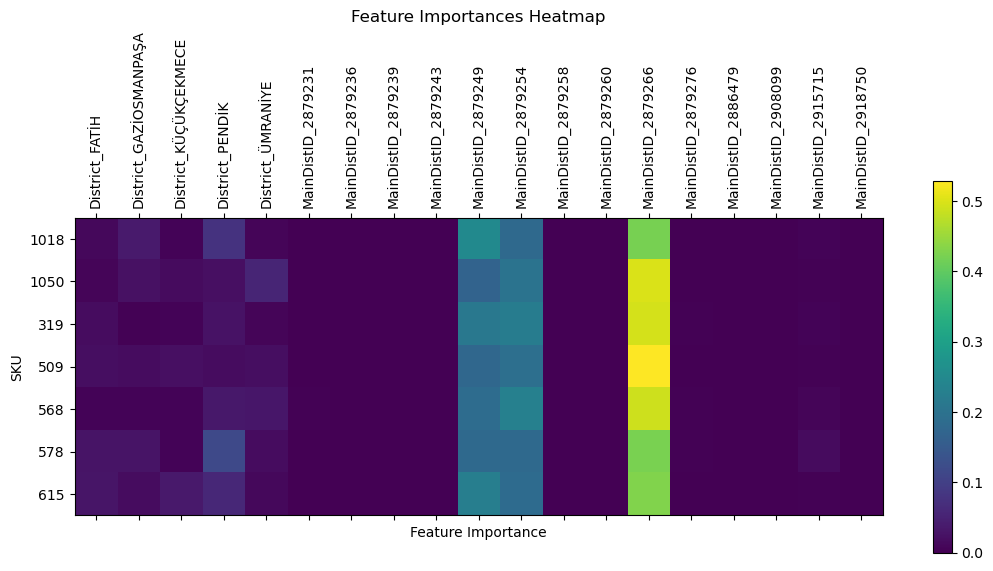

In [91]:
# heatmap for feature importances

plt.figure(figsize=(16, 10))
plt.matshow(feature_importances_df.drop('SkuID', axis=1), cmap='viridis')
plt.colorbar()
plt.xticks(range(len(feature_importances_df.columns) - 1), feature_importances_df.columns[1:], rotation=90)
plt.yticks(range(len(feature_importances_df)), feature_importances_df['SkuID'])
plt.xlabel('Feature Importance')
plt.ylabel('SKU')
plt.title('Feature Importances Heatmap')
plt.show()

In [92]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

def forecast_total_quantity(df, time_range, district, skuid):
    # Filter the dataframe for the given District and SkuID
    df_filtered = df[(df['District'] == district) & (df['SkuID'] == skuid)]
    
    # Aggregate data based on the time range
    if time_range == 'Quarter':
        df_agg = df_filtered.groupby(['District', 'SkuID', 'Year', 'Quarter']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + 'Q' + df_agg['Quarter'].astype(str))
        df_agg.set_index('Date', inplace=True)
        seasonal_periods = 4
        
    elif time_range == 'Month':
        df_agg = df_filtered.groupby(['District', 'SkuID', 'Year', 'Month']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + df_agg['Month'].astype(str).str.zfill(2), format='%Y%m')
        df_agg.set_index('Date', inplace=True)
        seasonal_periods = 12
        
    elif time_range == 'Week':
        df_agg = df_filtered.groupby(['District', 'SkuID', 'Year', 'Week']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + df_agg['Week'].astype(str).str.zfill(2) + '0', format='%Y%W%w')
        df_agg.set_index('Date', inplace=True)
        seasonal_periods = 52
        
    else:
        raise ValueError("Invalid time range. Choose from 'Quarter', 'Month', or 'Week'.")

    # Split the data into train and test sets
    train = df_agg.iloc[:-seasonal_periods]
    test = df_agg.iloc[-seasonal_periods:]
    
    # Fit the models and make forecasts
    models = {
        'Exponential Smoothing': ExponentialSmoothing(train['TotalQuantity'], seasonal='add', seasonal_periods=seasonal_periods).fit(),
        'ARIMA': ARIMA(train['TotalQuantity'], order=(5, 1, 0)).fit(),
        'SARIMA': SARIMAX(train['TotalQuantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_periods)).fit()
    }
    
    forecasts = {}
    metrics = {}
    
    for name, model in models.items():
        forecast = model.forecast(steps=seasonal_periods)
        forecasts[name] = forecast
        
        mape = mean_absolute_percentage_error(test['TotalQuantity'], forecast)
        mse = mean_squared_error(test['TotalQuantity'], forecast)
        rmse = np.sqrt(mse)
        bias = np.mean(forecast - test['TotalQuantity'])
        mad = mean_absolute_error(test['TotalQuantity'], forecast)
        
        metrics[name] = {
            'MAPE': mape,
            'MSE': mse,
            'RMSE': rmse,
            'Bias': bias,
            'MAD': mad
        }
    
    # Select the best model based on MAPE
    best_model_name = min(metrics, key=lambda k: metrics[k]['MAPE'])
    best_forecast = forecasts[best_model_name]
    
    return best_forecast, metrics[best_model_name]

# Example usage
df = df_cleaned_selected.copy()
forecast, metrics = forecast_total_quantity(df_cleaned, 'Month', 'PENDİK', '319')

print("Forecast:", forecast)
print("Metrics:", metrics)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97536D+00    |proj g|=  5.03320D-02

At iterate    5    f=  5.95255D+00    |proj g|=  5.89301D-03


 This problem is unconstrained.



At iterate   10    f=  5.95053D+00    |proj g|=  4.31550D-03

At iterate   15    f=  5.91751D+00    |proj g|=  1.56737D-02

At iterate   20    f=  5.91096D+00    |proj g|=  3.75838D-02

At iterate   25    f=  5.90950D+00    |proj g|=  2.74036D-03

At iterate   30    f=  5.90917D+00    |proj g|=  3.33458D-03

At iterate   35    f=  5.90749D+00    |proj g|=  1.93339D-02

At iterate   40    f=  5.89682D+00    |proj g|=  3.30318D-03

At iterate   45    f=  5.89661D+00    |proj g|=  2.82220D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     64      1     0     0   3.848D-06   5.897D+00
  F =   5.89661117002